# Team *Memento Mori* - be mindful of death!

In this project, we plan to analyze CDC Data to predict the likelihood of an individual dying from a natural cause or an unnatural cause.

# Trying to predict `unnatural`: plot things with this as hue

## Features to do EDA on: `detail_age`, `marital_status`, `education`, `sex`.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import (recall_score, f1_score, precision_score, accuracy_score, 
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

sns.set_style('whitegrid')

In [2]:
## Import the data
### Codes
json2015 = pd.read_json('2015_codes.json')

### Data
df2015 = pd.read_csv('2015_data.csv')

/Users/christiancofoid/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,41,42,43,61,62,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
## Take a sample from the data so that we aren't lugging around a 1.6gB array
# df_sample = df2015.sample(frac = 0.1, random_state = 33)

List the columns of the DataFrame `df2015`.

In [ ]:
df2015.columns

## Natural/Unnatural encoding

We now encode the deaths which we rule unnatural.  By an **unnatural death**, we mean a death which is caused by one of the following causes:
1. Accident: 
    1. unintentional injuries
    2. transportation
    3. motor vehicle, land/water/air/space
    4. nontransport accidents
    5. Falls
    6. Accidental discharge of firearms
    7. Accidental drowning
    8. Accidental exposure to smoke, fire, flames
    9. Accidental poisoning
2. Homicide:
    1. Assault, not by the below causes
    2. Assault with firearms
    3. Assault with unspecified means
3. Suicide:
    1. Suicide by means other than the causes below
    2. Suicide by discharge of firearm
    3. Suidice by unspecified means
4. Execution
5. Undetermined intent
    1. U.I. except those listed below
    2. Discharge of firearms, undetermined intent
    3. Other
6. Operations of war
7. Complications from medical and surgical care

These correspond to cause of death codes 112-135 in the feature `113_cause_recode`.

In [3]:
#obtain these codes from the 2015 json file
causes_113 = json2015[json2015['113_cause_recode'].isnull() == False]['113_cause_recode']
causes_113.index = list(map(int,causes_113.index))
causes_113.name = '113_cause_recode_json'

#extract unnatural causes labels
unnatural_causes = causes_113.index[111:]

In [ ]:
# df_sample['unnatural'] = 0
# df_sample.loc[(df_sample['113_cause_recode']<= max(unnatural_causes))
#           & (df_sample['113_cause_recode']>= min(unnatural_causes)),'unnatural']= 1

In [4]:
# df_sample.unnatural.value_counts(normalize = True)

In [5]:
# Make a custom transformer which will
## 1. code the features marital_status and sex
## 2. clean the education_2003_revision into a new 'education' feature
## 3. Encode the unnatural vs. natural deaths

# To put the education cleaning into a transformer

def educ_clean(row):
    row['education'] = row['education_2003_revision']
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] >=0) & 
        (row['education_1989_revision']<=8),'education'] = 1
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] >=9) & 
        (row['education_1989_revision']<=11),'education'] = 2
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] == 12),'education'] = 3
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] == 13),'education'] = 4
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] >= 14) & 
        (row['education_1989_revision'] <= 15),'education'] = 5
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] == 16),'education'] = 6
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] == 17), 'education'] = 7
    row.loc[(row['education_reporting_flag'] == 0) &
        (row['education_1989_revision'] == 99), 'education'] = 9
    return row


#Now put the EducTransformer into the CustomTransformer
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.OneHotEncoderMS = OneHotEncoder() #to encode marital_status of decedent
        self.OneHotEncoderSex = OneHotEncoder() #to encode sex of decedent
        self.EducTransformer = FunctionTransformer(educ_clean)
        
    def fit(self, X, y = None):        
        #fit the onehot for marital_status of decedent
        self.OneHotEncoderMS.fit(X[['marital_status']])
        
        #fit the onehot for sex of decedent
        self.OneHotEncoderSex.fit(X[['sex']])
        
        #fit the EducTransformer
        self.EducTransformer.fit(X)
        return self
        
    def transform(self, X, y = None):
        copy_X = X.copy()
        
        #encode marital_status of decedent
        ms_encoded = pd.DataFrame(self.OneHotEncoderMS.transform(copy_X[['marital_status']]).toarray(),
                               columns = self.OneHotEncoderMS.categories_[0],
                                 index = copy_X.index)
        
        #encode sex of decedent, removing one column (sex_M = 1-sex_F)
        sex_encoded = pd.DataFrame(self.OneHotEncoderSex.transform(copy_X[['sex']]).toarray(),
                               columns = ["sex_{}".format(x) for x in self.OneHotEncoderSex.categories_[0]],
                                  index = copy_X.index)
        sex_encoded = sex_encoded.copy()[['sex_M']]
        
        #now merge the two encoded dataframes from above
        copy_X = copy_X.join([ms_encoded, sex_encoded])
        
        #transform the education, drop the missing education (those with code 9)
        copy_X = self.EducTransformer.transform(copy_X)
        copy_X.drop(copy_X[copy_X.education == 9].index, axis = 0, inplace = True)
        
        #encode the natural/unnatural death
        copy_X['unnatural'] = 0
        copy_X.loc[(X['113_cause_recode']<= max(unnatural_causes))
                   & (X['113_cause_recode']>= min(unnatural_causes)),'unnatural']= 1
        
        #drop the missing (999) ages
        copy_X.drop(copy_X[copy_X['detail_age'] == 999].index, axis = 0, inplace = True)
        
        return copy_X
        

In [6]:
#Create the AgeTransformer, which replaces missing ages (those coded 999) with 
# the median age, by sex, and then applies a StandardScaler
### To be applied after the CustomTransformer has been applied.

class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.StandardScaler = StandardScaler()
    
    def fit(self, X, y = None): 
        #Fit the StandardScaler on the non-999 (non-missing) ages
        
        self.StandardScaler.fit(X[['detail_age']])
        return self
    
    def transform(self, X, y = None):
        copy_X = X.copy()
        
        #now standardize ages
        copy_X['detail_age'] = self.StandardScaler.transform(copy_X[['detail_age']])
        
        return copy_X


## `education`: cleaning the 1989_recoding problem

In the feature `education_revision_2003` some of the instances are using a 1989 code, and these are the codes which are `nan` values.  Unstated education levels are encoded with a `99`.  The `nan` value in `education_revision_2003` is indicated with a 0 in the `education_reporting_flag` feature.  We use the feature `education_reporting_flag` to create a new feature, `education` which return the 2003 education revision and updates the instances which use the 1989 revision.  Values of `9`, which are unreported, are retained.

In [7]:
CT = CustomTransformer()
CT.fit(df2015)
df2015_transform = CT.transform(df2015)

In [ ]:
# We are missing about 4.5% of the education data -- use a simple imputer?
df_sample[df_sample.education == 9].shape[0]/df_sample.shape[0]

<IPython.core.display.Javascript object>


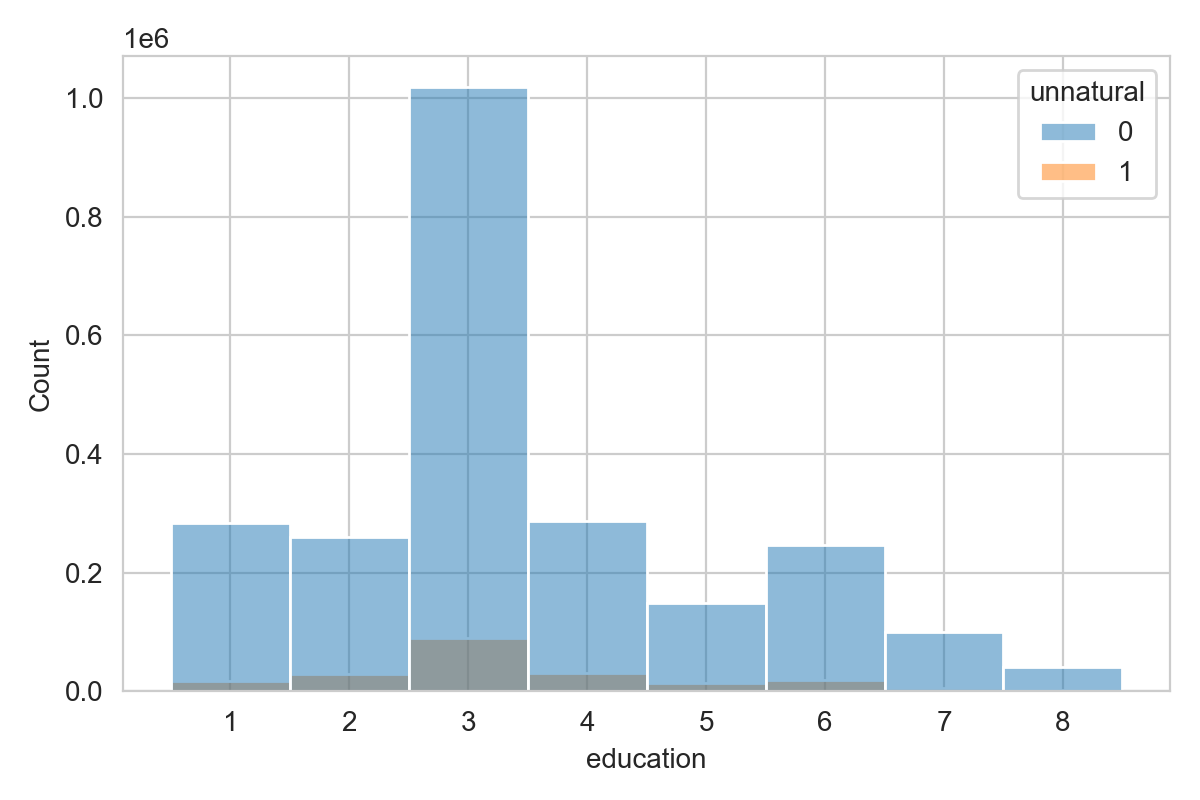

In [8]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df2015_transform,
            x = 'education',
            hue = 'unnatural',
#             stat = 'probability',
            bins = np.arange(1,10)-0.5
            );
fig.tight_layout()

Unnatural deaths increase as education level increases until a person has completed high-school or obtained a GED, then they began to decrease after completing some college.  

For natural deaths, there is a slight decrease from pre-high school to some high-school, but this can be explained by variable `detail_age`.

### `detail_age`

There needs to be some cleaning of the data to determine the age of the decedent, particularly in the case of the death of an infant.  I'm not sure what's going on with the feature `detail_age` or if that has been condensed down to an integer representing number of years lived.  

Note that ages which are missing are encoded as 999.  There aren't many, so we can just fill them with the median age for the particular value of `sex`.  Use the `AgeTransformer`, but **ONLY FOR PLOTTED DATA**

In [ ]:
# PlotAT = AgeTransformer()
# PlotAT.fit(df_sample)
# age_toplot = PlotAT.transform(df_sample)


In [ ]:
# age_toplot.detail_age.max()

<IPython.core.display.Javascript object>


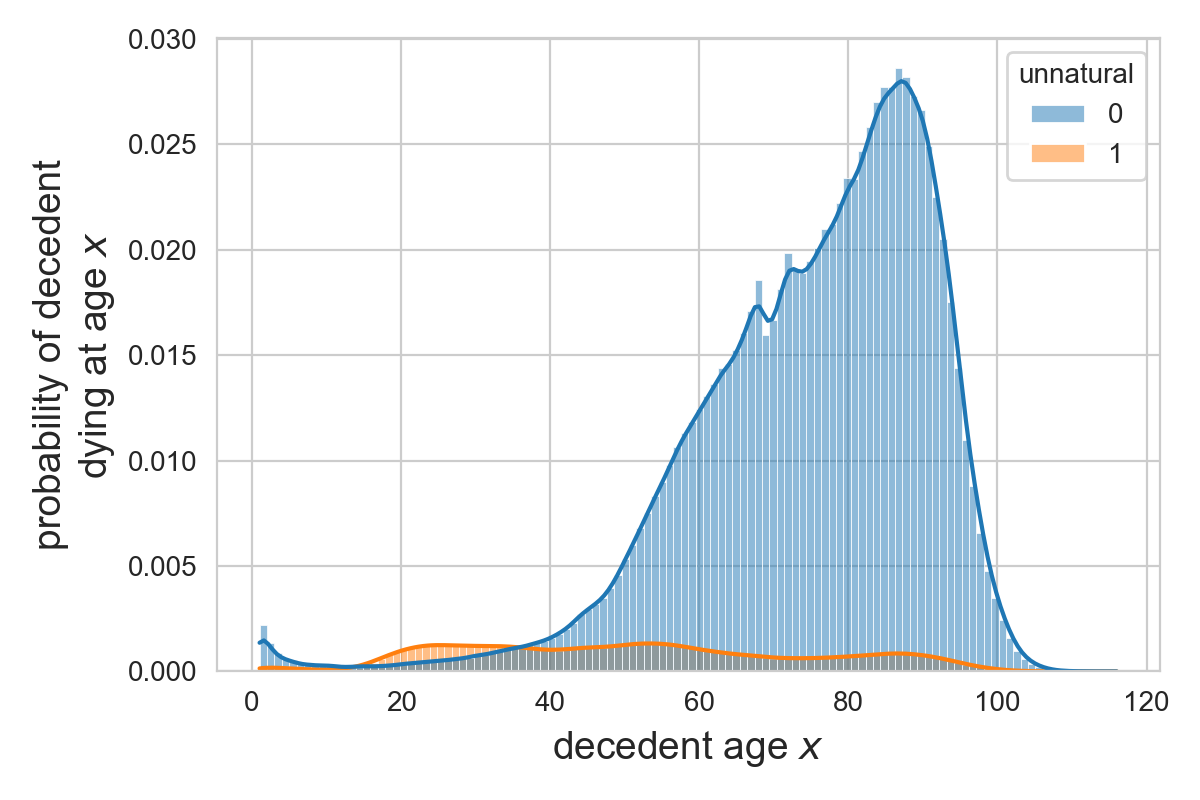

In [16]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df2015_transform,
            x = 'detail_age',
            hue = 'unnatural',
            stat='probability', 
            kde = True,
            bins = len(df2015_transform.detail_age.unique()));
ax.set_xlabel('decedent age $x$', fontsize = 14)
ax.set_ylabel('probability of decedent\ndying at age $x$', fontsize = 14)
fig.tight_layout()

<IPython.core.display.Javascript object>


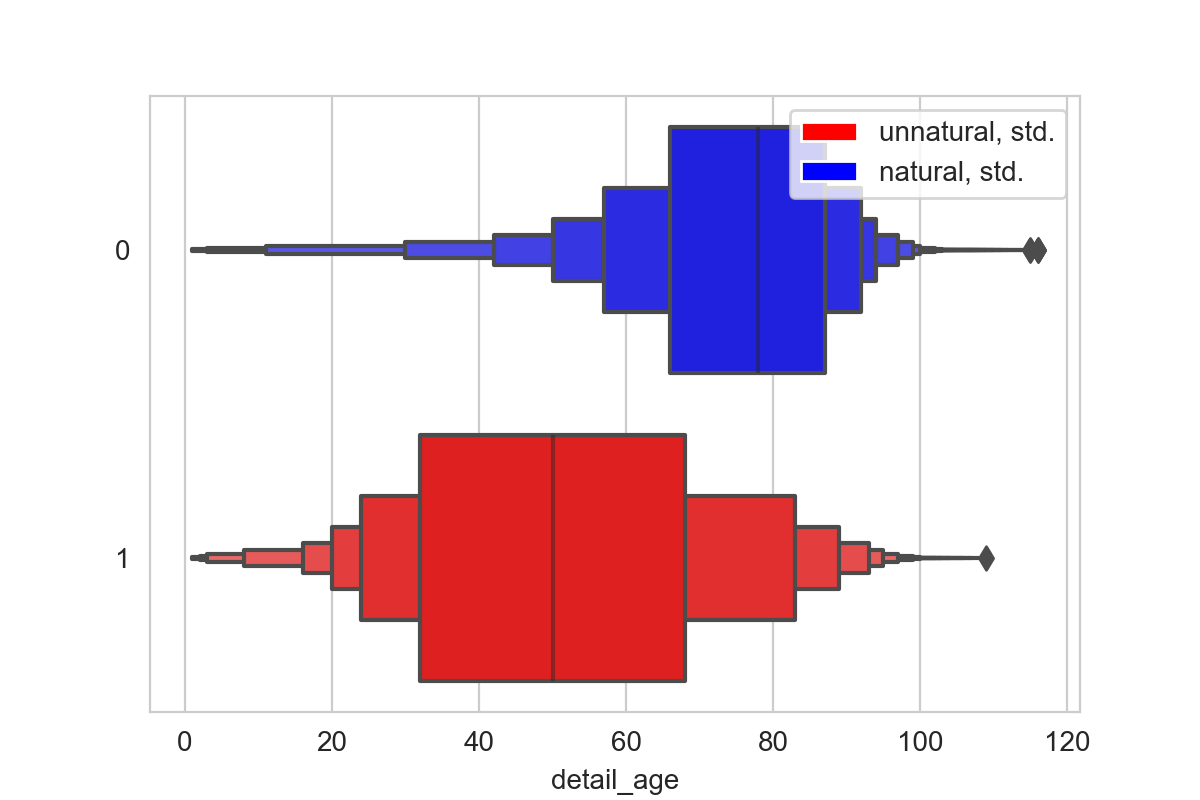

In [17]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.boxenplot(x="detail_age", y="unnatural", 
            data=df2015_transform, orient="h",
            palette={1:"red", 0:"blue"}, ax=ax,)

color_patches = [
    Patch(facecolor="red", label="unnatural, std."),
    Patch(facecolor="blue", label="natural, std.")]
    
ax.set_ylabel('')
ax.legend(handles = color_patches);



The number of instances when the age is recorded as 1, but the child died between the time of birth and the age of 1 is tiny compared to the number of observations: about $0.25\%$ of the instances correspond to this scenario.

<IPython.core.display.Javascript object>


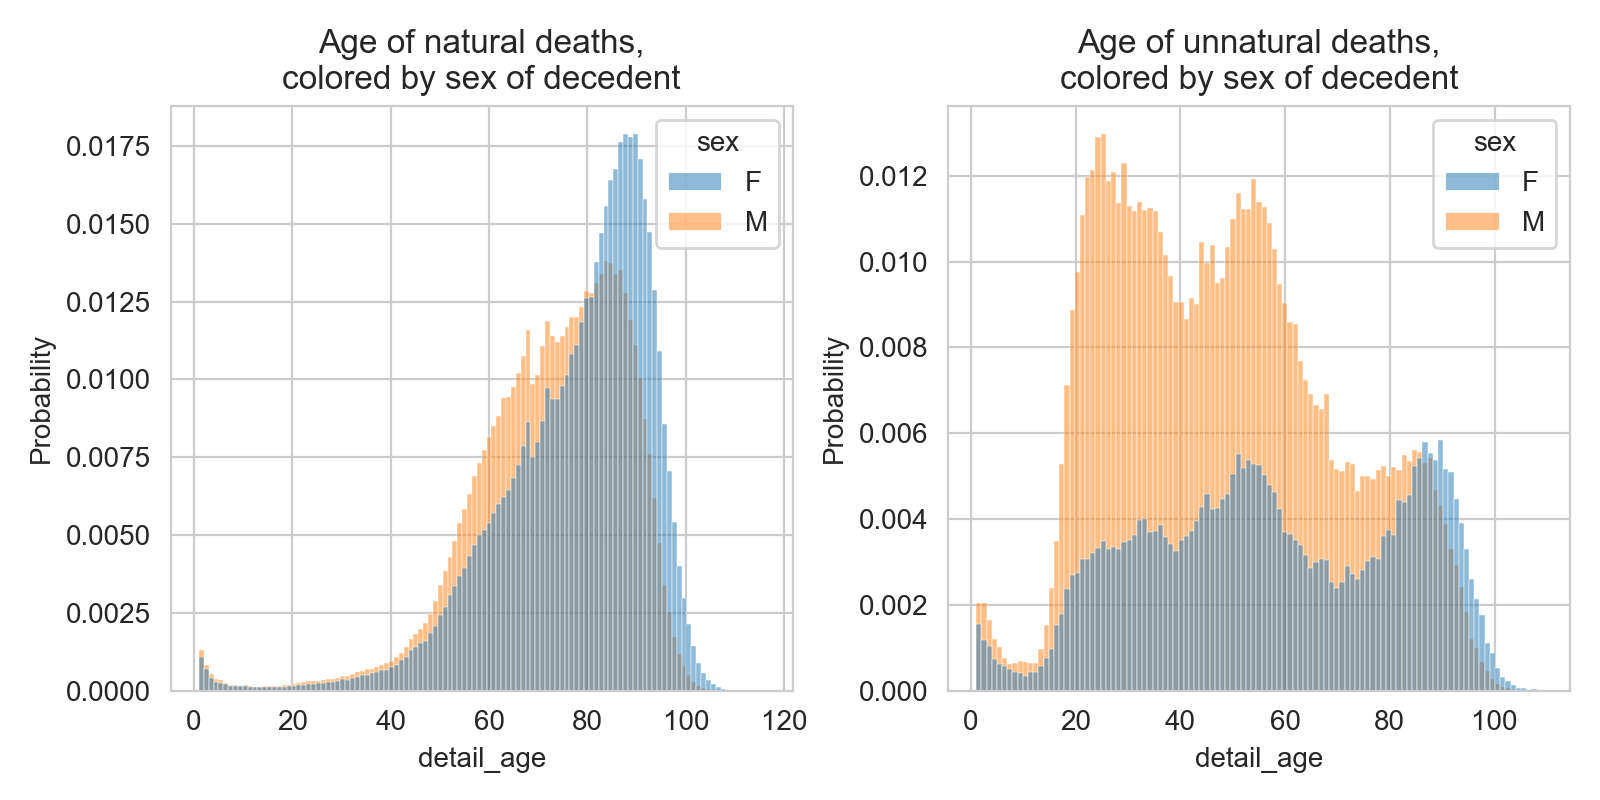

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df2015_transform[df2015_transform.unnatural == 0],
            x = 'detail_age',
            ax = ax[0],
            hue = 'sex',
             stat = 'probability',
             hue_order = ['F','M'],
            bins = 116) #np.arange(1,age_toplot.detail_age.max())
            
ax[0].set_title('Age of natural deaths,\ncolored by sex of decedent')
# ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df2015_transform[df2015_transform.unnatural == 1],
            x = 'detail_age',
            ax = ax[1],
            hue = 'sex',
             stat = 'probability',
             hue_order = ["F","M"],
            bins = 109 #np.arange(1,age_toplot.detail_age.max())
            )
ax[1].set_title('Age of unnatural deaths,\ncolored by sex of decedent')
# ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

#### Conclusions:
1. Different means and different skewness
2. Many outliers for the `unnatural = 0` group.
3. This makes sense -- natural deaths tend to happen later in life, while there are certainly outliers which happen early, due to childhood/adolescent disease, as well as disease in early adulthood.  Unnatural deaths are more likely to occur when a person is out in the world exposed to danger -- this more frequently happens to middle-aged adults as they go about their business and work.


A printout of the summary statistics of the distribution of `detail_age`, by `unnatural`:

In [21]:
age_group = df2015_transform.groupby('unnatural')

def quantile(x,q):
    return np.quantile(x,q)
age_group_agg = age_group.agg({"detail_age":[("mean",np.mean),
                             ("min",np.min), 
                             ("q_25",lambda x: quantile(x,0.25)),
                             ('median',np.median), 
                             ("q_75",lambda x: quantile(x,0.75)),
                             ('max',np.max), ]})['detail_age']
print('Summary of the feature detail_age, by unnatural:')
print('====================================================')
print(age_group_agg)

Summary of the feature detail_age, by unnatural:
                mean  min  q_25  median  q_75  max
unnatural                                         
0          75.224439    1  66.0    78.0  87.0  116
1          51.199433    1  32.0    50.0  68.0  109


### `marital_status`

<IPython.core.display.Javascript object>


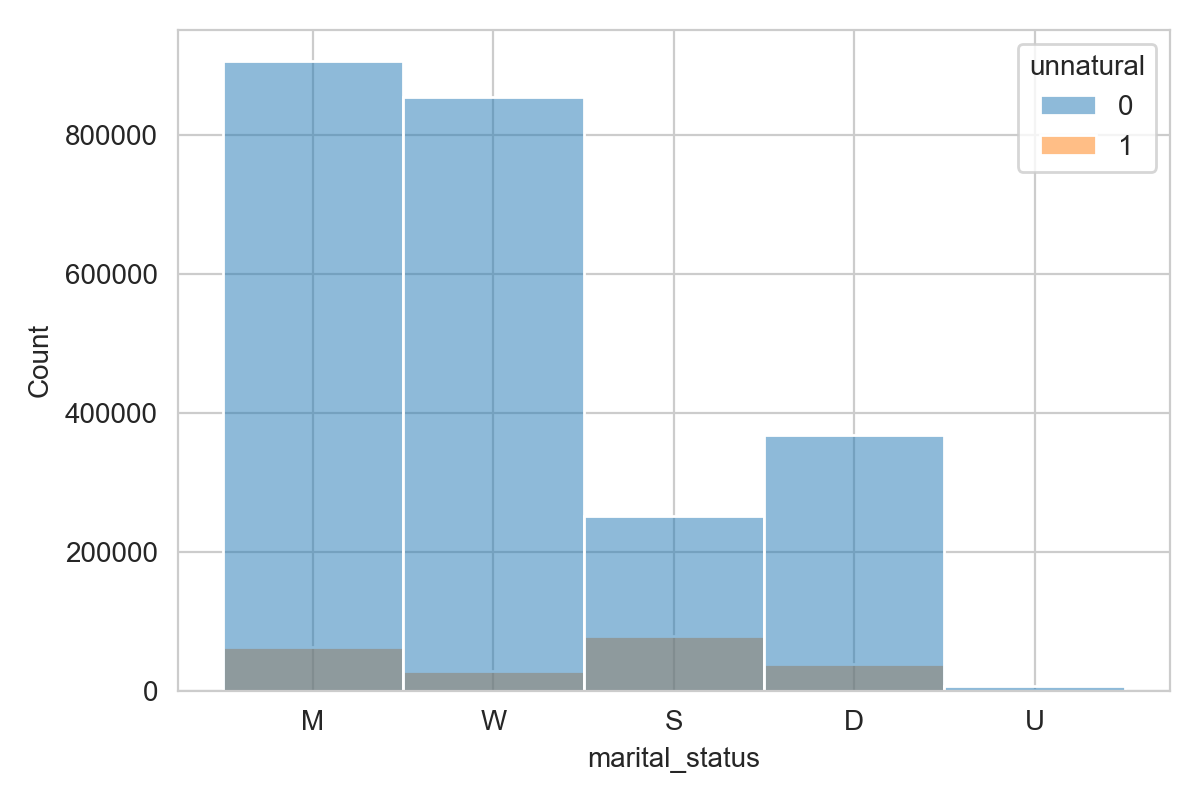

In [22]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df2015_transform,
            x = 'marital_status',
            hue = 'unnatural',
#             stat = 'probability',
#             bins = np.arange(1,10)-0.5
            );
fig.tight_layout()

<IPython.core.display.Javascript object>


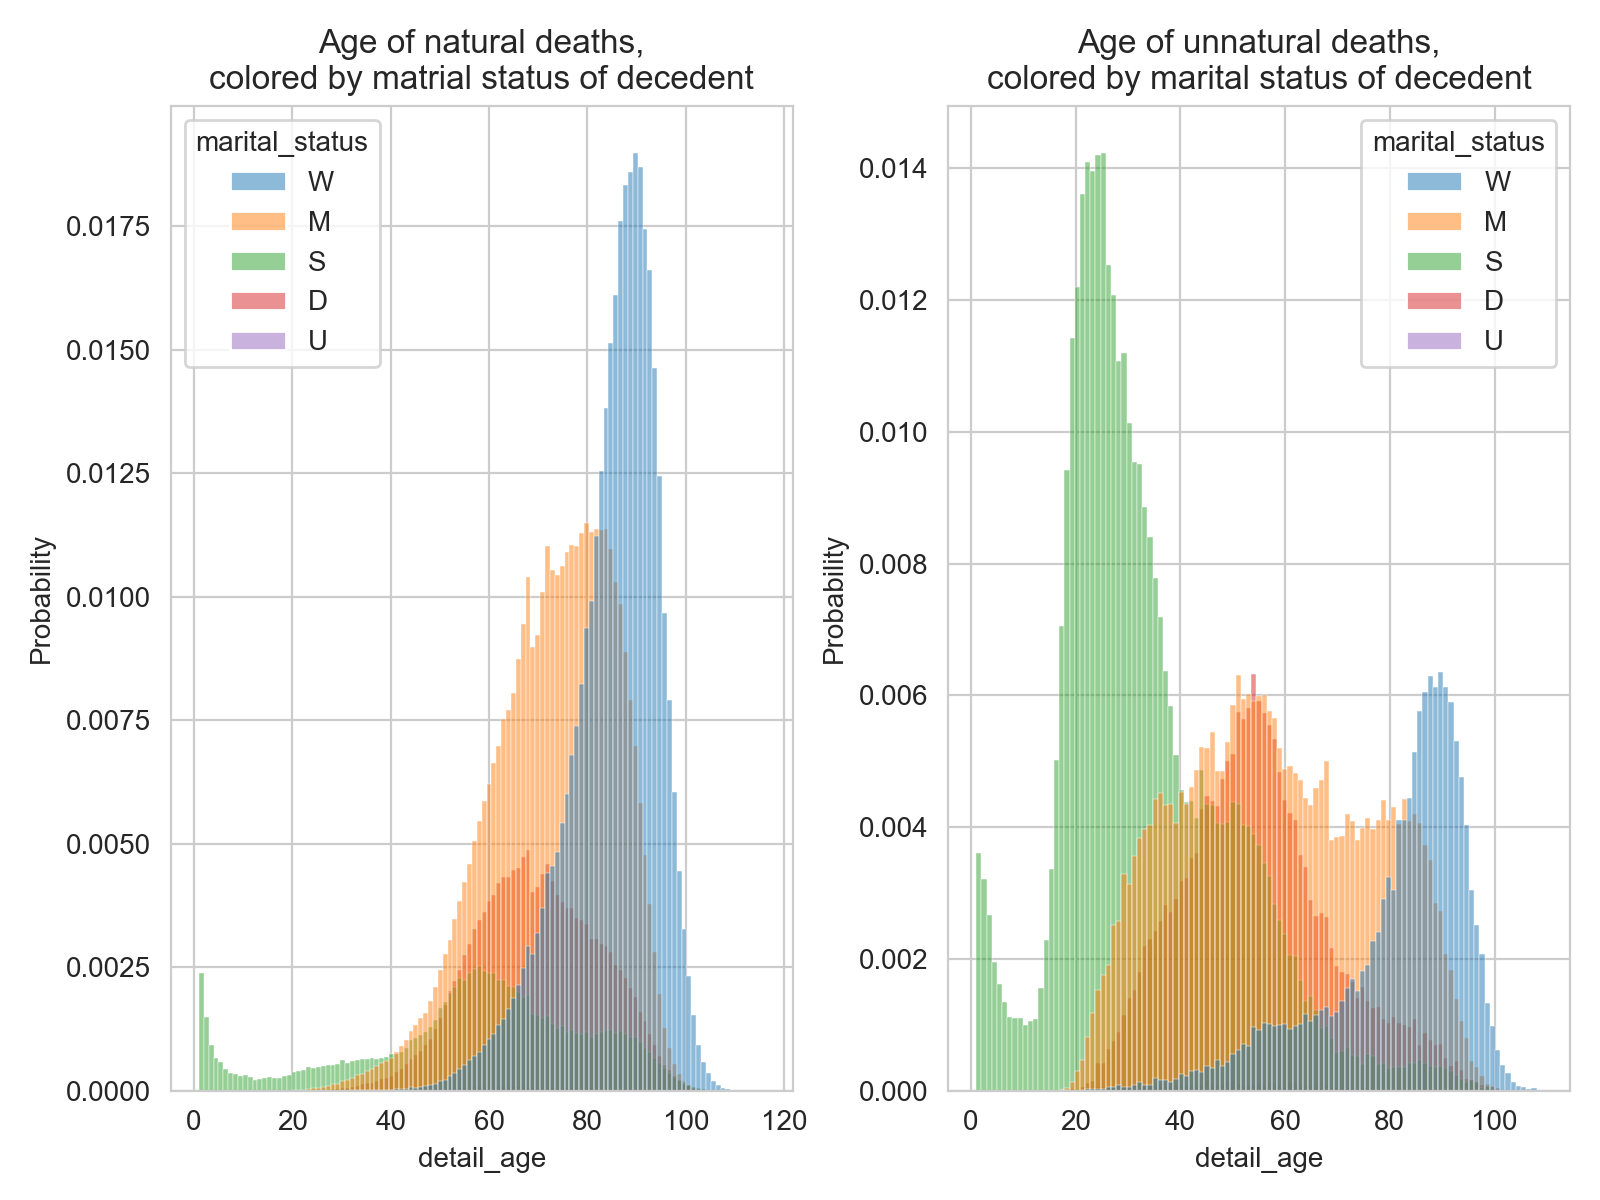

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (8,6))

#first plot is of the age distribution of natural deaths
sns.histplot(data = df2015_transform[(df2015_transform.unnatural == 0)],
            x = 'detail_age',
            ax = ax[0],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = 116,
#              np.arange(1,df_sample.detail_age.max())
            )
ax[0].set_title('Age of natural deaths,\ncolored by matrial status of decedent')
# ax[0].set_xticks(range(0,115,10))

#second plot is of the age distribution of unnatural deaths
sns.histplot(data = df2015_transform[(df2015_transform.unnatural == 1)],
            x = 'detail_age',
            ax = ax[1],
            hue = 'marital_status',
             hue_order = ['W','M','S','D','U'],
             stat = 'probability',
            bins = 109)
#              np.arange(1,df_sample.detail_age.max()))
ax[1].set_title('Age of unnatural deaths,\ncolored by marital status of decedent')
# ax[1].set_xticks(range(0,115,10))
fig.tight_layout()

### `resident_status`

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'resident_status',
            hue = 'unnatural',
#             stat = 'probability',
             bins = [1,2,3,4,5]
            );
ax.set_xticks([i + 0.5 for i in range(1,5)])
ax.set_xticklabels([i for i in range(1,5)])
fig.tight_layout()

<!-- <span style= "color: red">
    11/12/22: I will return to this later... Going to check Ramazan's model first.
</span> -->
### `month_of_death`

In [ ]:
# agg_month_of_death = df_sample.groupby('month_of_death').agg({'unnatural':len})

# plt.bar(x = agg_month_of_death.index,
#        height = agg_month_of_death.values.reshape(-1,))
# plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

sns.histplot(data = df_sample,
            x = 'month_of_death',
            hue = 'unnatural',
#             stat = 'probability',
             bins = range(1,14)
            );
ax.set_xticks([i + 0.5 for i in range(1,13)])
ax.set_xticklabels([i for i in range(1,13)])
fig.tight_layout()

### `race`

In [ ]:
race_group = df_sample.groupby('race')
unnatural_by_race = race_group.agg({'unnatural':[("total", len),("unnatural_count",sum)]})['unnatural']
unnatural_by_race['cond_prob_unnat'] = unnatural_by_race['unnatural_count']/unnatural_by_race['total']

race_dct = {key: val for key, val in zip(sorted(df_sample.race.unique()),
    ["White","Black", "American Indian", "Chinese",
     "Japanese", "Hawaiian", "Filipino","Asian Indian",
     "Korean", "Samoan", "Vietnamese", "Guamanian",
     "Other Asian\nor P.I.","Combined Other\nAsian or P.I.",
                                          "Combined Other\nAsian or P.I.",
                                          "Asian Indian"])} 

#codes 78 and 81 I am taking to be the following:
    #78: On the Combined other Asian or Pacific Islander
    #81: miswriting of 18, so Asian Indian

for r in unnatural_by_race.index:
    unnatural_by_race.loc[r,'Race'] = race_dct[r]

In [ ]:
unnatural_by_race

Let $R$ be the random variable indicating a decedent's race, and $U$ be the random variable indicating the type of death (unnatural = 1, natural = 0).  We plot the distribution $P(U = 1|R = r)$ for each race $r\in \mathtt{race\underline{\,\,\,}dct.values}$.

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (8,8))

ax[0].bar(x = unnatural_by_race.Race,
      height= unnatural_by_race.cond_prob_unnat,
      alpha = 0.7)
ax[0].set_ylabel('$P(U = 1|R = r)$')
ax[0].set_xticklabels(unnatural_by_race.Race, rotation = 70)
ax[0].set_title('Probability of unnatural death, by race $r$')

ax[1].bar(x = unnatural_by_race.Race,
          height = np.log10(unnatural_by_race.total),
          alpha = 0.7
         )
ax[1].set_ylabel('$\log(\mathtt{count})$')
ax[1].set_xticklabels(unnatural_by_race.Race, rotation = 70)
ax[1].set_title('Log deaths by unnatural causes, by race $r$')
fig.tight_layout()

# Checking Ramazan's work:
Ramazan used the features `['education_2003_revision', 'month_of_death', 'age_recode_52', 'detail_age', 'day_of_week_of_death', 'activity_code']`, but I am going to replace `education_2003_revision` with the cleaned education feature `education`.

In [ ]:
R_features = ['education_2003_revision','age_recode_52','sex','resident_status','marital_status']
C_features = ['education','detail_age', 'sex', 'resident_status','marital_status']

df_sample[C_features].info()

In [ ]:
# make a train_test_split to df_sample
train, test = train_test_split(df_sample, test_size = 0.2, 
                              random_state = 1907, 
                              shuffle = True,
                              stratify = df_sample.unnatural)

In [38]:
updated_ftu = ['education',
              'detail_age',
               'D', 'M', 'S', 
               'U', 'W', 'sex_M']

In [ ]:
n_splits = 10
n_models = 5
kfold = StratifiedKFold(n_splits = n_splits,
                        shuffle = True, 
                        random_state = 1907)
#axis 0: index of the kfold 
#axis 1: for the score type: recall, f1
#axis 2: for the model number
results = np.zeros((n_splits, 2, n_models))

#might use this, but probably not.
model_lst = [LogisticRegression(max_iter = 10000),
            LogisticRegression(max_iter = 10000, class_weight = 'balanced'),
            RandomForestClassifier(n_estimators = 100, max_depth = 8),
            RandomForestClassifier(n_estimators=100, max_depth=8 ,class_weight = 'balanced')]

In [ ]:
i = 0
for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    #make the train and holdhout sets
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    #fit the five models
    
    #Model 0: Classify as all zeros
    all_zeros = np.zeros(train_ho.unnatural.shape[0])
    results[i,0,0] = f1_score(all_zeros, train_ho.unnatural, zero_division = 0)
    results[i,1,0] = recall_score(train_ho.unnatural, all_zeros, zero_division = 0)
    print(f'Model 0 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                all_zeros),'\n')
    
    #Model 1: Logistic Regression: no weights
    lr1 = Pipeline([('scaler',AgeTransformer()),
                    ('lr1',LogisticRegression())])
    
    lr1.fit(train_tt[updated_ftu], train_tt.unnatural)
    lr1_pred = lr1.predict(train_ho[updated_ftu])
    
    results[i,0,1] = f1_score(train_ho.unnatural, lr1_pred)
    results[i,1,1] = recall_score( train_ho.unnatural, lr1_pred)
    print(f'Model 1 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                lr1_pred),'\n')
    
    #Model 2: Logistic Regressin: weights
    lr2 = Pipeline([('scaler',AgeTransformer()),
                     ('lr2',LogisticRegression(class_weight = 'balanced'))])
    
    lr2.fit(train_tt[updated_ftu],train_tt.unnatural)
    lr2_pred = lr2.predict(train_ho[updated_ftu])
    
    results[i,0,2] = f1_score(train_ho.unnatural, lr2_pred)
    results[i,1,2] = recall_score(train_ho.unnatural, lr2_pred)
    print(f'Model 2 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                lr2_pred),'\n')
    
    
    #Model 3: Random Forest: no weights
    rf1 = Pipeline([('scaler',AgeTransformer()),
                   ('rf1',RandomForestClassifier())])
    
    rf1.fit(train_tt[updated_ftu],train_tt.unnatural)
    rf1_pred = rf1.predict(train_ho[updated_ftu])
    
    results[i,0,3] = f1_score(train_ho.unnatural, rf1_pred)
    results[i,1,3] = recall_score(train_ho.unnatural, rf1_pred)
    print(f'Model 3 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                    rf1_pred),'\n')
    print(rf1.named_steps['rf1'].feature_importances_)
    
    #Model 4: Random Forest: weights
    rf2 = Pipeline([('scaler',AgeTransformer())
            ,("rf2",RandomForestClassifier(class_weight='balanced'))])
    
    rf2.fit(train_tt[updated_ftu],train_tt.unnatural)
    rf2_pred = rf2.predict(train_ho[updated_ftu])
    
    results[i,0,4] = f1_score(train_ho.unnatural, rf2_pred)
    results[i,1,4] = recall_score(rf2_pred, train_ho.unnatural)
    print(f'Model 4 {i}th validation \n', 
          classification_report(train_ho['unnatural'].values,
                                rf2_pred),'\n')
    print(rf2.named_steps['rf2'].feature_importances_)
    
    
    i+= 1
    

In [ ]:
results.mean(axis= 0)

In [ ]:
model_names = ['Most Frequent Class',
               'LR()',
               "LR(class_weight = 'balanced')",
               'RFC()',
               "RFC(class_weight = 'balanced')"]
index = ['f1_score','recall_score']
pd.DataFrame(results.mean(axis= 0).T, index = model_names, columns = index)

In [ ]:
train[updated_ftu]

In [ ]:
i = 0

logreg_recall = np.zeros(n_splits)

for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    #apply the AgeTransformer 
    # -- can't do this as a pipeline because the variable 'sex' is necessary for 
    #    the AgeTransformer, but cannot be used in the LogReg, since LogReg takes 
    #    numerical data only.    
    
    logreg = Pipeline([('AT', AgeTransformer()),
                       ('logreg', LogisticRegression(class_weight = 'balanced'))])
    
    logreg.fit(train_tt[updated_ftu], train_tt.unnatural)
    
    preds = logreg.predict(train_ho[updated_ftu])
    pred_proba = logreg.predict_proba(train_ho[updated_ftu] )[:,1]
    logreg_recall[i] = recall_score(y_true = train_ho.unnatural,
                                y_pred = preds)
    
    
    tpr_i, fpr_i, cutoffs_i = roc_curve(y_true = train_ho.unnatural, y_score= pred_proba)
    
    fig, ax = plt.subplots(1,1,figsize = (4,4))
    ax.plot(tpr_i, fpr_i, label = "ROC Curve for validation {}".format(i))
    ax.plot([0,1],[0,1], '-', label = 'Random Guessing')
    ax.set_xlabel('FPR')
    ax.set_ylabel("TPR")
    ax.legend(loc = 0)
    print(i)
    i+=1

In [ ]:
logreg_recall.mean(axis = 0)

## Hyperparameter tuning for balanced LogisticRegression 

We will tune the regularization parameter $C$ for our weighted logistic regression model using a GridSearch.  We will conduct this grid search using the a larger sample of 20\% of the original 2015 data.

In [115]:
# CT1 = CustomTransformer()
# CT1.fit(df2015)
# df2015_transform = CT1.transform(df2015)

train, test = train_test_split(df2015_transform, 
                               test_size = 0.2, 
                               stratify = df2015_transform.unnatural,
                              random_state = 123)

In [57]:
train_train, train_test = train_test_split(train, test_size = 0.2,
                                          random_state = 123,
                                          stratify = train.unnatural)

In [58]:
n_splits = 10
kfold = StratifiedKFold(n_splits = n_splits,
                        shuffle = True,
                       random_state = 33)

Cs = [10**j for j in range(-10,0)] + [0.25, 0.5, 1,2,5,10]

#column 0 is recall
#column 1 is precision
#columns 2 is f1_macro
logreg_tuning_scores = np.zeros((n_splits, 3, len(Cs)))

In [36]:
len(Cs)

16

In [106]:
updated_ftu = ['education',
              'detail_age',
               'D', 'M', 'S', 
               'U', 'W', 'sex_M']

i = 0

for tt_ix, ho_ix in kfold.split(train_train, train_train.unnatural):
    
    train_tt, train_ho = train_train.iloc[tt_ix], train_train.iloc[ho_ix]
    
    j = 0
    for c in Cs:
        logreg = Pipeline([('AT', AgeTransformer()),
                       ('logreg', LogisticRegression(C = c, 
                                                     class_weight = 'balanced',
                                                    random_state = 123))])
    
        logreg.fit(train_tt[updated_ftu], train_tt.unnatural)

        preds = logreg.predict(train_ho[updated_ftu])
        pred_proba = logreg.predict_proba(train_ho[updated_ftu] )[:,1]
        logreg_tuning_scores[i,0,j] = recall_score(y_true = train_ho.unnatural,
                            y_pred = preds)
        logreg_tuning_scores[i,1,j] = precision_score(y_true = train_ho.unnatural,
                    y_pred = preds)
        logreg_tuning_scores[i,2,j] = f1_score(y_true = train_ho.unnatural,
                                               y_pred = preds, average = 'macro')
        
        
        j+=1
    print(i)
    i+=1 
    


0
1
2
3
4
5
6
7
8
9


In [107]:
mean_recalls = logreg_tuning_scores.mean(axis = 0)[0,:]
mean_precisions = logreg_tuning_scores.mean(axis = 0)[1,:]
mean_f1_macros = logreg_tuning_scores.mean(axis = 0)[2,:]

In [108]:
best_c_recall_ix = np.where(mean_recalls == mean_recalls.max())[0][0]
best_c_precision_ix = np.where(mean_precisions == mean_precisions.max())[0][0]
best_c_f1macro_ix = np.where(mean_f1_macros == mean_f1_macros.max())[0][0]
pd.DataFrame({"Best Train Score":[mean_recalls.max(), mean_precisions.max(), mean_f1_macros.max()],
             "Best C index":[best_c_recall_ix, best_c_precision_ix, best_c_f1macro_ix],
             "Best C":[Cs[best_c_recall_ix], Cs[best_c_precision_ix], Cs[best_c_f1macro_ix]] },
            index = ['recall','precision','f1_macro'])

,Best Train Score,Best C index,Best C
recall,0.783511,0,1.000000e-10
precision,0.230618,3,1.000000e-07
f1_macro,0.609832,3,1.000000e-07


In [109]:
# validate the best recall model:
best_recall_logreg = Pipeline([("AT",AgeTransformer()),
                              ('logreg',LogisticRegression(C = Cs[best_c_recall_ix],
                                                          class_weight='balanced',
                                                      random_state = 123))])

best_recall_logreg.fit(train_train[updated_ftu], train_train.unnatural)

#best recall predictions
best_recall_preds = best_recall_logreg.predict(train_test[updated_ftu])

#best recall predict_proba (for class 1)
best_recall_predproba = best_recall_logreg.predict_proba(train_test[updated_ftu])[:,1]

#best recall 
best_recall = recall_score(y_true = train_test.unnatural,
                          y_pred = best_recall_preds)

#best recall ROC curve
fpr, tpr, cutoffs = roc_curve(y_true = train_test.unnatural,
                             y_score = best_recall_predproba)

print('Recall on LogReg with best c = {} is {:0.6f}.'.format(Cs[best_c_recall_ix],
                                                       best_recall))

Recall on LogReg with best c = 1e-10 is 0.783331.


In [110]:
#baseline model: guess 1 with probability equal to the training proportion of unnatural deaths
p = train_train.unnatural.sum()/train_train.shape[0]

#baseline predictions
baseline = np.array([np.random.binomial(1, p = p) for i in train_test.unnatural.index])

#baseline predict_proba
baseline_proba = np.array([p for i in train_test.unnatural.index])

#print baseline recall
print('Baseline recall is {:0.6f}.'.format(recall_score(y_true = train_test.unnatural,
            y_pred = baseline)))

#compute baseline ROC curve
baseline_fpr, baseline_tpr, baseline_cutoffs = roc_curve(y_true = train_test.unnatural,
                                                        y_score=baseline_proba)


Baseline recall is 0.079744.


<IPython.core.display.Javascript object>


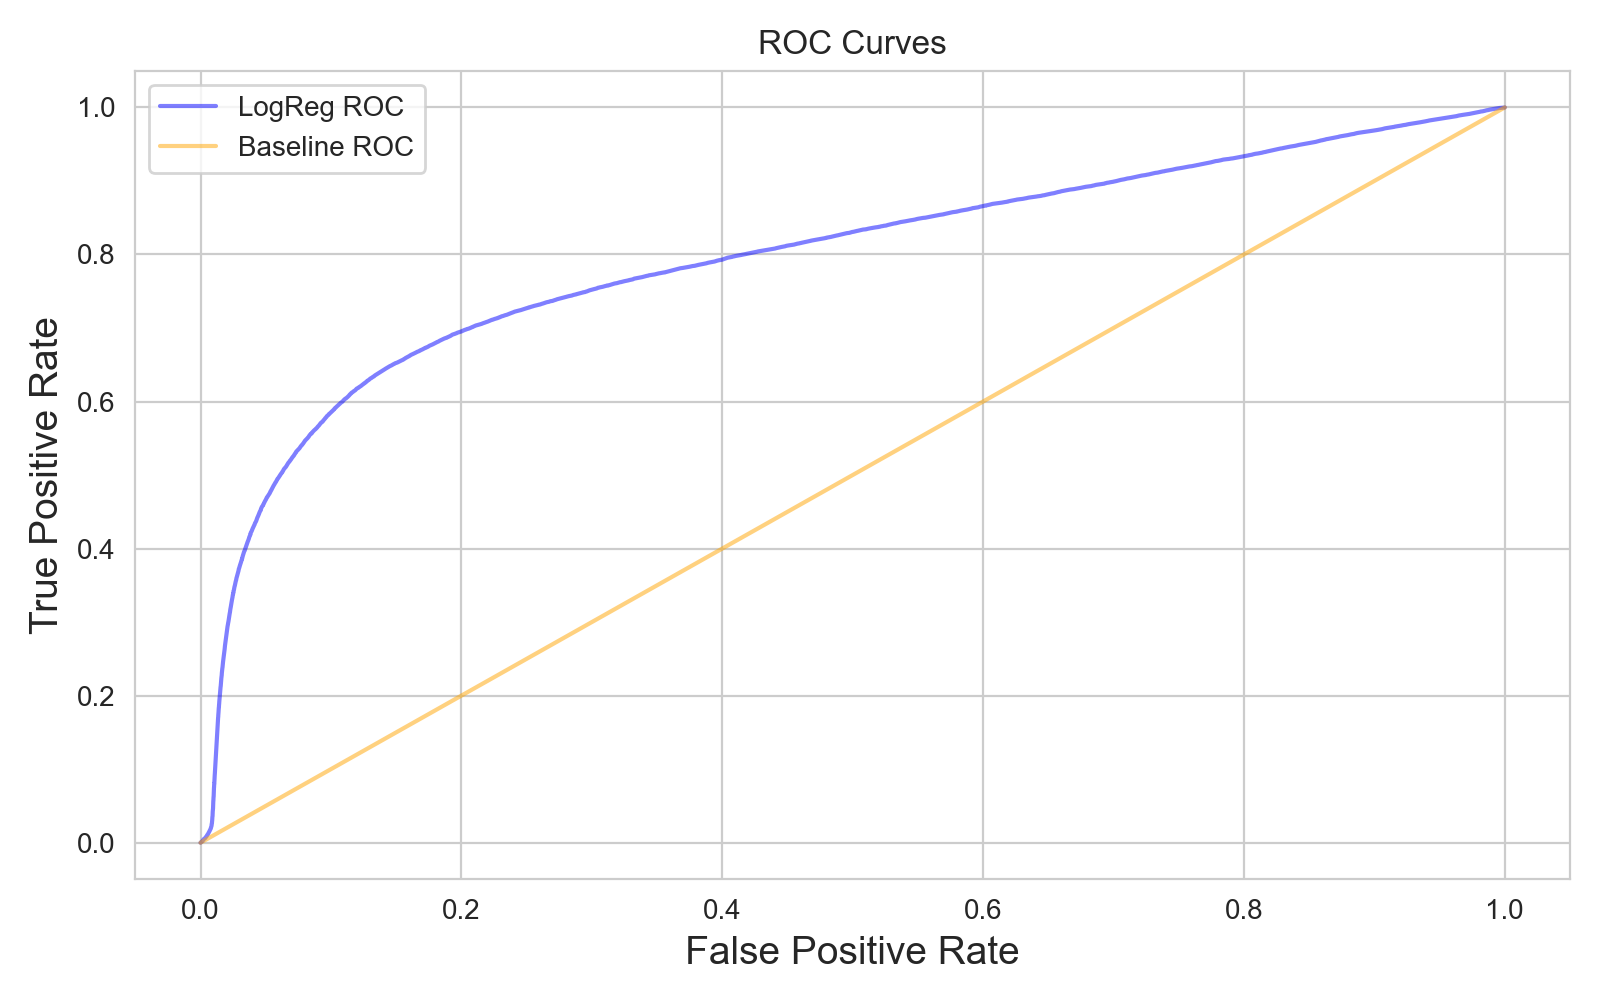

In [111]:
#Plot the ROC Curve for the best_c_logreg and the baseline
fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.plot(fpr, tpr,  
        label = 'LogReg ROC',
        alpha = 0.5,
       color = 'blue')

ax.plot(baseline_fpr, baseline_tpr,
       label = 'Baseline ROC',
       color = 'orange',
       alpha = 0.5,
       )
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title('ROC Curves')
ax.legend(loc = 0)
fig.tight_layout()

In [178]:
n_splits

10

In [245]:
kfold_for_gs = StratifiedKFold(n_splits = n_splits,
                              shuffle = True, 
                              random_state = 123,)

estimator = Pipeline(steps = [("AT",AgeTransformer()),
                      ("logreg",LogisticRegression(class_weight = 'balanced'))])

param_grid = {"logreg__C": [i*10**(-10) for i in range(1,10)]}

logreg_gridsearch = GridSearchCV(estimator = estimator, 
                          param_grid = param_grid,
                          scoring = 'recall',
                         cv = kfold_for_gs)

In [216]:
estimator.get_params()

{'memory': None,
 'steps': [('AT', AgeTransformer()),
  ('logreg', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'AT': AgeTransformer(),
 'logreg': LogisticRegression(class_weight='balanced'),
 'logreg__C': 1.0,
 'logreg__class_weight': 'balanced',
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

In [246]:
logreg_gridsearch.fit(train_train[updated_ftu],train_train.unnatural)
# sklearn.metrics.get_scorer_names()
# LogisticRegression()

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('AT', AgeTransformer()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'logreg__C': [1e-10, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10,
                                       7.000000000000001e-10, 8e-10, 9e-10]},
             scoring='recall')

In [248]:
print("Best C is {}.".format(logreg_gridsearch.best_params_['logreg__C']))
print("Best recall is {:0.6f}.".format(logreg_gridsearch.best_score_))

Best C is 1e-10.
Best recall is 0.783392.


<IPython.core.display.Javascript object>


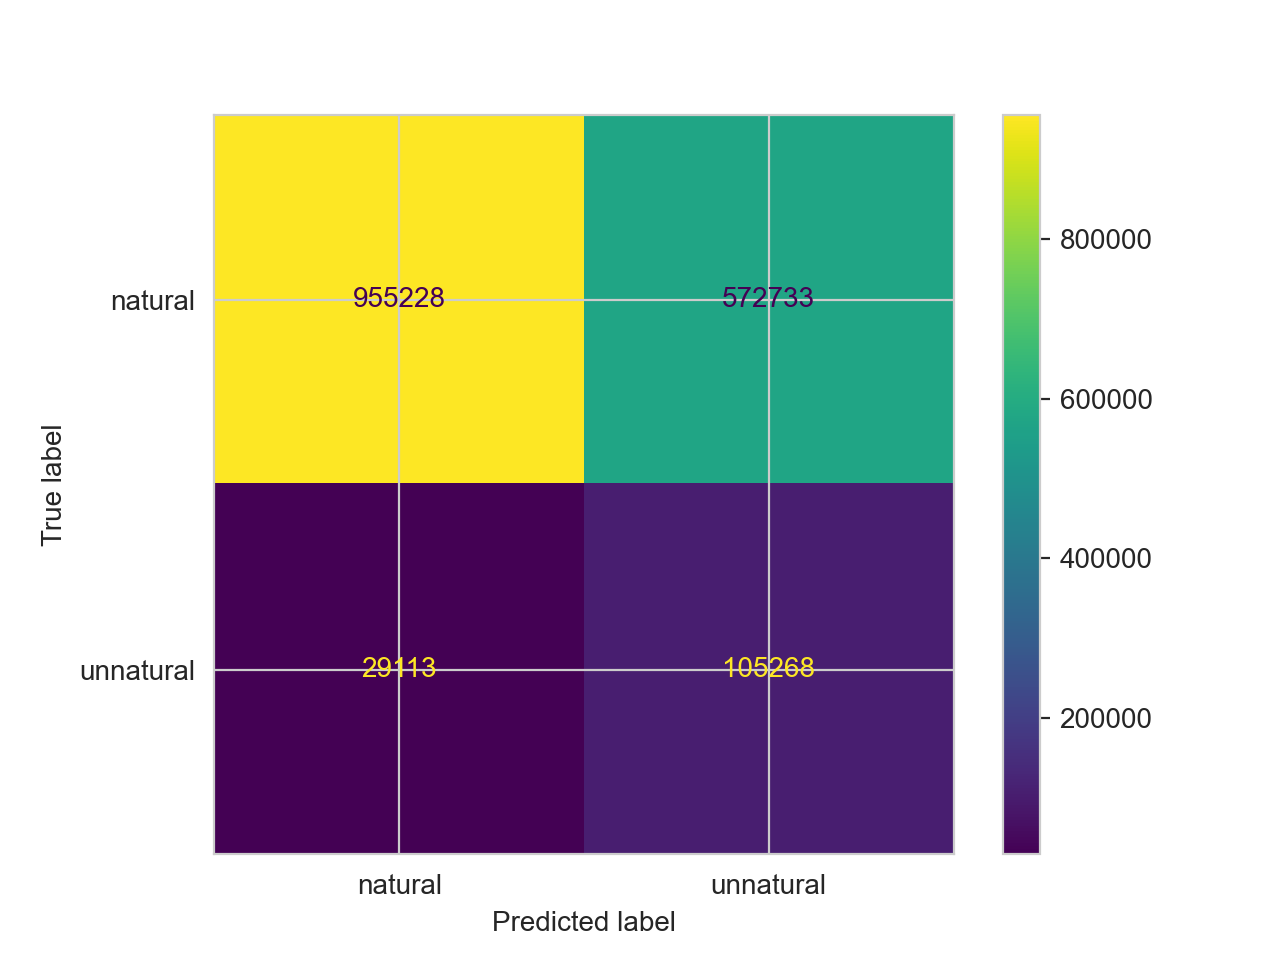

In [249]:
cm = confusion_matrix(y_true = train_train.unnatural,
                     y_pred = logreg_gridsearch.best_estimator_.predict(train_train[updated_ftu]))

disp_cm = ConfusionMatrixDisplay(cm,
                                 display_labels = ['natural','unnatural'])

disp_cm.plot()


## Meeting 11/28/22
- Baseline model: Bernouli($p = 0.08$)
- Can record the precision \& $f_1$ \& $f_{1,macro}$ as well
- Try XGBoost, Under/Oversampling (?)
    - Hypertuning RandomForest -- after this, narrow down choice of model
    - Compare to LogisticRegression with $c = $`best_c`: if other models are not as good, go with simpler model
- Score on training set to compare -- use the same `random_state = 123` 
- Use train_test_split to take a 20/% sample using the stratification according to unnatural. 

- Ramazan: RF and hypertuning it
- Christian: XGBoost and hypertuning it: in wherever you put the cross_val number, put the `kfold` object.
- Mark: presentation (Information about the dataset, EDA and many pictures, selling the project to a company)
    - advertising via mail to collect information, put a rate out there for the potential insured, special-offer mailing for insurance companies
    - could be A/B tested (advert. rates based on model versus advert. rates based on normal procedure)
        - advertising accuracy (less of a sticker shock)
    - this is why it’s okay to keep the unknown marital status
    - data is easy demographic data to obtain

## XGBoosting

In [113]:
import xgboost as xgb

In [233]:
train_train2, train_test2 = train_test_split(train, 
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 123, 
                                             stratify = train.unnatural)

In [223]:
kfold2 = StratifiedKFold(n_splits = 10, shuffle = True,
                        random_state = 123)

weights = np.arange(700,900,50)

param_grid = {'XGB__scale_pos_weight':weights}

xgb_estimator = Pipeline([("AT",AgeTransformer()),
                        ("XGB",xgb.XGBClassifier(n_estimators = 10, 
                                  max_depth = 8,
                                  random_state = 123))])


In [225]:
xgb_gridsearch = GridSearchCV(estimator = xgb_estimator,
                             param_grid = param_grid,
                             scoring = 'recall',
                             cv = kfold2)

xgb_gridsearch.fit(train_train[updated_ftu], train_train.unnatural)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('AT', AgeTransformer()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=8,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=10,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=123, ...))]),
             param_grid={'XGB__scale_pos_weight': array([700, 750, 800, 850])},
             scoring='recall')

In [227]:
xgb_gridsearch.best_params_

{'XGB__scale_pos_weight': 700}

In [232]:
xgb_val_preds = xgb_gridsearch.best_estimator_.predict(train_test[updated_ftu])
xgb_val_recall = recall_score(y_pred = xgb_val_preds, y_true = train_test.unnatural)
xgb_val_recall

0.9997618693257925

Woah...

In [254]:
f1_score(y_pred = xgb_val_preds, y_true = train_test.unnatural,)

0.14964401236823108

<IPython.core.display.Javascript object>


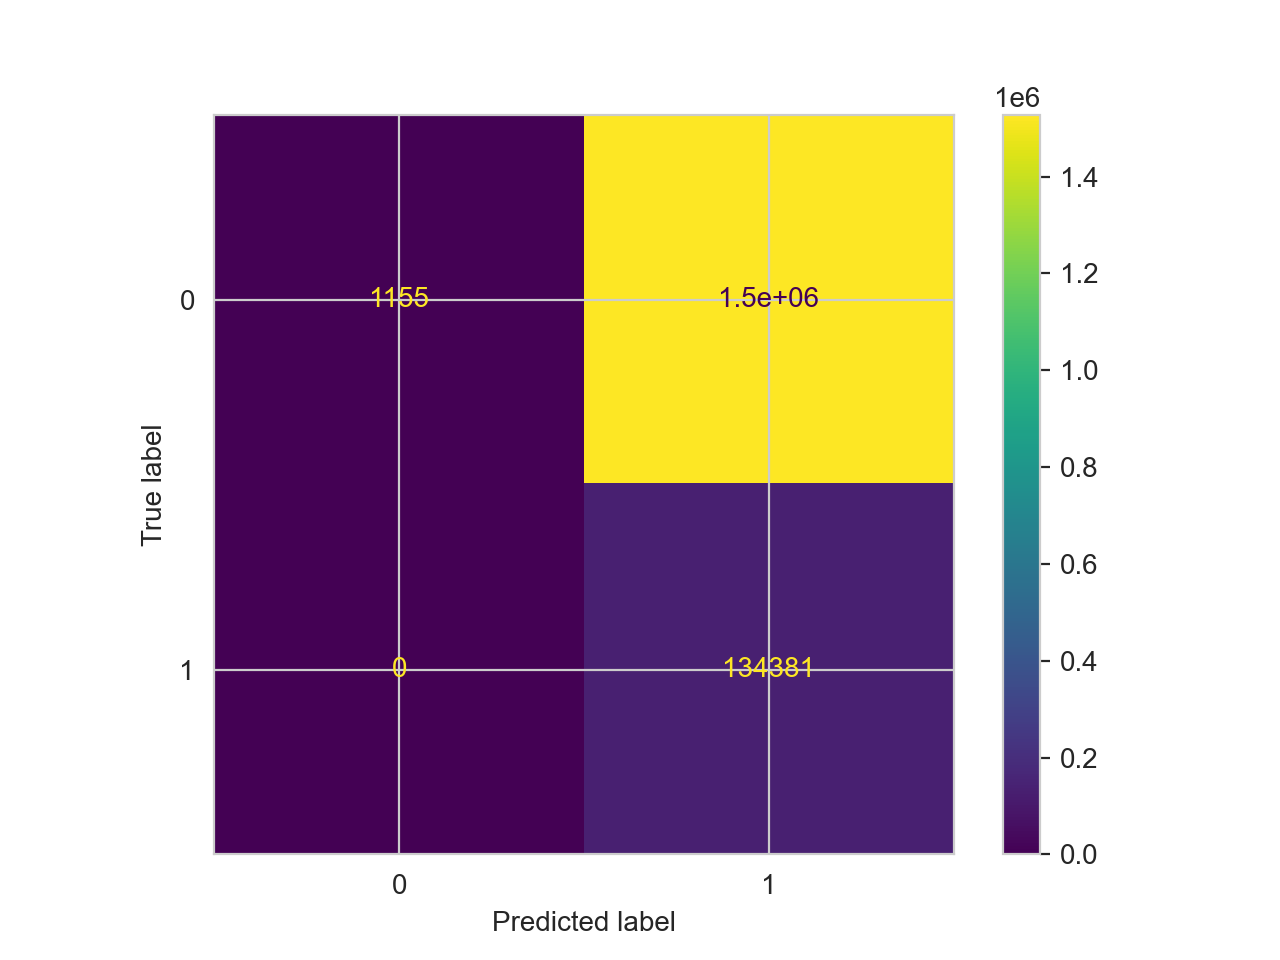

In [250]:
xgb_cm = confusion_matrix(y_true = train_train.unnatural,
                y_pred = xgb_gridsearch.best_estimator_.predict(train_train[updated_ftu]))
ConfusionMatrixDisplay(xgb_cm).plot()

### Naive Bayes

In [ ]:
#try Naive Bayes
i = 0

nb_recalls = np.zeros((n_splits))

for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    nb = BernoulliNB()
    nb.fit(train_tt[updated_ftu], train_tt.unnatural)
    
    preds = nb.predict(train_ho[updated_ftu])
    
    nb_recalls[i] = recall_score(y_true = train_ho.unnatural,
                                y_pred = preds)
    i+=1
    

In [ ]:
nb_recalls.mean() #This is not a good score... like 28%

In [ ]:
updated_ftu

## Linear Separability: first pass is to plot

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (9,9))
#rewrite the features for the loop.
plot_feats = [['education','marital_status'],['resident_status','sex']]
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.scatterplot(data = df_sample,
               x = 'detail_age',
               y = plot_feats[i][j],
               hue = 'unnatural',
               ax = ax[i,j]);
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4))

sns.scatterplot(data = df_sample, 
               x = 'detail_age',
               y = 'race',
               hue = 'unnatural');

By plotting a discrete feature against `detail_age`, the data are not separable in two dimensions.  Let's make a linear SVC to see to what degree the data are linearly separable.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

i = 0

svc_accuracy_lin = np.zeros((n_splits))
svc_recall_lin = np.zeros(n_splits)

for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    svc_pipe = Pipeline([('svc',SVC(kernel = 'linear'))])
    
    svc_pipe.fit(train_tt[updated_ftu], train_tt.unnatural)
    
    preds = svc_pipe.predict(train_ho[updated_ftu])
    
    svc_accuracy_lin[i] = accuracy_score(y_true = train_ho.unnatural,
                                y_pred = preds)
    svc_recall_lin[i] = recall_score(y_true = train_ho.unnatural,
                                y_pred = preds)
    print(i)
    i+=1
print()
print("SVC_acc: {}".format(svc_accuracy_lin.mean()))
print("SVC_recall: {}".format(svc_recall_lin.mean()))

In [ ]:
svc = SVC(C = 1,
          kernel = 'linear',
         random_state = 1907)
svc.fit(train[updated_ftu], train.unnatural)



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(svc.predict(train[updated_ftu]),
                train.unnatural)


disp_cm = ConfusionMatrixDisplay(cm,display_labels = svc.classes_)

disp_cm.plot()


In [ ]:
from sklearn.metrics import roc_curve

i = 0

logreg_recall = np.zeros(n_splits)

for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    logreg = LogisticRegression(class_weight='balanced')
    
    logreg.fit(train_tt[updated_ftu + ['race']], train_tt.unnatural)
    
    preds = logreg.predict(train_ho[updated_ftu + ['race']])
    pred_proba = logreg.predict_proba(train_ho[updated_ftu + ['race']] )[:,1]
    logreg_recall[i] = recall_score(y_true = train_ho.unnatural,
                                y_pred = preds)
    
    
    tpr_i, fpr_i, cutoffs_i = roc_curve(y_true = train_ho.unnatural, y_score= pred_proba)
    
    fig, ax = plt.subplots(1,1,figsize = (4,4))
    ax.plot(tpr_i, fpr_i, label = "ROC Curve for validation {}".format(i))
    ax.plot([0,1],[0,1], '-', label = 'Random Guessing')
    ax.set_xlabel('FPR')
    ax.set_ylabel("TPR")
    ax.legend(loc = 0)
    print(i)
    i+=1

In [ ]:
logreg_recall.mean()

In [ ]:
logreg_recall

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
updated_ftu_1 = ['education','detail_age','D', 'M','S','U','W','sex_M']

i = 0
n_estimators = range(1,26)

ada_boost_recall = np.zeros((n_splits, len(n_estimators)))

n_splits = 10
kfold = StratifiedKFold(n_splits = n_splits)

for tt_ix, ho_ix in kfold.split(train, train.unnatural):
    
    train_tt, train_ho = train.iloc[tt_ix], train.iloc[ho_ix]
    
    j = 0
    for n in n_estimators:
    
        ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2,
                                                                            random_state = 1907),
                                       n_estimators = n)

        ada_boost.fit(train_tt[updated_ftu_1], train_tt.unnatural)

        preds = ada_boost.predict(train_ho[updated_ftu_1])
        pred_proba = ada_boost.predict_proba(train_ho[updated_ftu_1] )[:,1]
        ada_boost_recall[i,j] = recall_score(y_true = train_ho.unnatural,
                                    y_pred = preds)
        j+= 1

#         tpr_i, fpr_i, cutoffs_i = roc_curve(y_true = train_ho.unnatural, y_score= pred_proba)

#         fig, ax = plt.subplots(1,1,figsize = (4,4))
#         ax.plot(tpr_i, fpr_i, label = "ROC Curve for validation {}".format(i))
#         ax.plot([0,1],[0,1], '-', label = 'Random Guessing')
#         ax.set_xlabel('FPR')
#         ax.set_ylabel("TPR")
#         ax.legend(loc = 0)

    print(i)
    i+=1

In [ ]:
ada_boost_recall.mean(axis = 0)

### Return to EDA: Friedman's $H$ Statistic

From *Interpretable Machine Learning*: "One way to estimate the interaction strength is to measure how much of the variation of the prediction depends on the interaction of the features. This measurement is called H-statistic, introduced by Friedman and Popescu (2008)." From https://christophm.github.io/interpretable-ml-book/interaction.html#theory-friedmans-h-statistic

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [ ]:
log_reg = LogisticRegression(class_weight = 'balanced')
log_reg.fit(train[updated_ftu], train.unnatural)
predicted_proba = log_reg.predict_proba(test[updated_ftu])

In [ ]:
for i, x in enumerate(updated_ftu + ['unnatural']):
    print(i, x)

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    log_reg,
    train[updated_ftu],
    features=[0,1,9,(0,1)],
)